In [ ]:
#ConvLSTM-SED   multivariable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-TVFEMD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_DJH.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)

timestep = 6
dim = 2
#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:2]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)

#print(X_scaler)
#print(Y_scaler)
#print(Y)


# 将数据拆分成训练和测试，8/9作为训练数据
train_size = int(len(dataset) * 0.89)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX)
#print(trainY)
#print(testX)
#print(testY)



#重构数据集
##timestep为时间步长
def create_trainX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_trainY(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i + timestep])
    return np.array(dataY)

def create_testX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[(i):(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------

pres=[]
trainX = create_trainX(trainX, timestep)
trainY = create_trainY(trainY, timestep)
testX = create_testX(testX, timestep) 
testY = testY[timestep:len(testY)]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = np.reshape(trainX, (trainX.shape[0], 2,1,timestep//2, dim))
testX_input5D = np.reshape(testX, (testX.shape[0],2,1,timestep//2, dim))
#trainX_input5D = np.reshape(trainX, (trainX.shape[0], timestep,1,1, dim))
#testX_input5D = np.reshape(testX, (testX.shape[0],timestep,1,1, dim))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=12, kernel_size=(2,2), activation='relu', 
                         input_shape=(2,1,timestep//2, dim),
#                         input_shape=(timestep,1,1, dim),
                         padding='same', return_sequences=True))
    model.add(ConvLSTM2D(filters=12, kernel_size=(1,1), activation='relu',
                         padding='same', return_sequences=True))
    
    #model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=700)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)

    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

#ConvLSTM-SED   multivariable

In [ ]:
#TSRConvLSTM-SED-(2,2)
import numpy
import pandas
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
numpy.random.seed(7)

start = time.time()

# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_DJH.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)
Y = dataset[:,0]#Y
Y_scaler= (Y-numpy.min(Y))/(numpy.max(Y)-numpy.min(Y))
Y_scaler = Y_scaler.reshape(-1)

X = dataset[:,1]
X_scaler= (X-numpy.min(X))/(numpy.max(X)-numpy.min(X))
X_scaler = X_scaler.reshape(-1)

XX = numpy.zeros([324,2,2])
XX[:,0,0] = Y_scaler
XX[:,0,1] = X_scaler
XX[:,1,0] = X_scaler
XX[:,1,1] = Y_scaler

# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
train, test = XX[0:train_size,:,:], XX[train_size:len(dataset),:,:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)


# 切片
def create_train(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
        # Y向后移动一位取值
        dataY.append(seq[i + timestep,:,:])
    return numpy.array(dataX), numpy.array(dataY)

def create_testX(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
    return numpy.array(dataX)
# fix random seed for reproducibility
numpy.random.seed(7)



#----------forecasting-----------
timestep = 6
pres=[]
trainX,trainY = create_train(train, timestep)
testX = create_testX(test, timestep) 
testY = test[timestep:len(X),0,0]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = numpy.reshape(trainX, (trainX.shape[0], timestep,2,2, 1))
testX_input5D = numpy.reshape(testX, (testX.shape[0],timestep, 2,2, 1))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
from tensorflow.python.keras.layers.convolutional import Conv3D ,Conv2D
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=12, kernel_size=(2, 2), activation='relu', input_shape=(timestep, 2,2,1),
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=12, kernel_size=(2, 2),activation='relu',
                         padding='same',return_sequences=False))
    model.add(Conv2D(filters=1, kernel_size=(1, 1),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
    #model.add(Flatten())
    #model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=1000)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)
    
    # 逆缩放预测值
    testPredict1 = testPredict[:,0,0,:]
    testPredict1 = testPredict1.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict1*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

数据集的长度： 324
原始训练集的长度： 288
原始测试集的长度： 36
转为监督学习，训练集数据长度： 282
转为监督学习，测试集数据长度： 30
构造得到模型的输入数据(训练数据已有标签trainY):  (282, 1, 6, 2) (30, 1, 6, 2)
Train on 282 samples
Epoch 1/1000
282/282 [==============================] - 1s 2ms/sample - loss: 0.1689
Epoch 2/1000
282/282 [==============================] - 0s 57us/sample - loss: 0.1037
Epoch 3/1000
282/282 [==============================] - 0s 78us/sample - loss: 0.0577
Epoch 4/1000
282/282 [==============================] - 0s 64us/sample - loss: 0.0318
Epoch 5/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0204
Epoch 6/1000
282/282 [==============================] - 0s 99us/sample - loss: 0.0175
Epoch 7/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0171
Epoch 8/1000
282/282 [==============================] - 0s 110us/sample - loss: 0.0168
Epoch 9/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0164
Epoch 10/1000
282/282 [==============================] - 0s 67us/sam

282/282 [==============================] - 0s 67us/sample - loss: 0.0040
Epoch 93/1000
282/282 [==============================] - 0s 71us/sample - loss: 0.0040
Epoch 94/1000
282/282 [==============================] - 0s 71us/sample - loss: 0.0039
Epoch 95/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0039
Epoch 96/1000
282/282 [==============================] - 0s 64us/sample - loss: 0.0039
Epoch 97/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0039
Epoch 98/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0039
Epoch 99/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0038
Epoch 100/1000
282/282 [==============================] - 0s 57us/sample - loss: 0.0038
Epoch 101/1000
282/282 [==============================] - 0s 64us/sample - loss: 0.0038
Epoch 102/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0038
Epoch 103/1000
282/282 [==============================

282/282 [==============================] - 0s 67us/sample - loss: 0.0028
Epoch 186/1000
282/282 [==============================] - 0s 67us/sample - loss: 0.0027
Epoch 187/1000
282/282 [==============================] - 0s 71us/sample - loss: 0.0027
Epoch 188/1000
282/282 [==============================] - 0s 57us/sample - loss: 0.0027
Epoch 189/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0027
Epoch 190/1000
282/282 [==============================] - 0s 57us/sample - loss: 0.0027
Epoch 191/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0027
Epoch 192/1000
282/282 [==============================] - 0s 57us/sample - loss: 0.0027
Epoch 193/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0027
Epoch 194/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0027
Epoch 195/1000
282/282 [==============================] - 0s 57us/sample - loss: 0.0026
Epoch 196/1000
282/282 [=======================

282/282 [==============================] - 0s 64us/sample - loss: 0.0018
Epoch 279/1000
282/282 [==============================] - 0s 64us/sample - loss: 0.0018
Epoch 280/1000
282/282 [==============================] - 0s 64us/sample - loss: 0.0018
Epoch 281/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0018
Epoch 282/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0018
Epoch 283/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0018
Epoch 284/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0018
Epoch 285/1000
282/282 [==============================] - 0s 64us/sample - loss: 0.0017
Epoch 286/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0018
Epoch 287/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0017
Epoch 288/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0017
Epoch 289/1000
282/282 [=======================

282/282 [==============================] - 0s 64us/sample - loss: 0.0012
Epoch 372/1000
282/282 [==============================] - 0s 67us/sample - loss: 0.0012
Epoch 373/1000
282/282 [==============================] - 0s 64us/sample - loss: 0.0012
Epoch 374/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0012
Epoch 375/1000
282/282 [==============================] - 0s 57us/sample - loss: 0.0012
Epoch 376/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0012
Epoch 377/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0012
Epoch 378/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0012
Epoch 379/1000
282/282 [==============================] - 0s 60us/sample - loss: 0.0012
Epoch 380/1000
282/282 [==============================] - 0s 64us/sample - loss: 0.0012
Epoch 381/1000
282/282 [==============================] - 0s 57us/sample - loss: 0.0012
Epoch 382/1000
282/282 [=======================

282/282 [==============================] - 0s 60us/sample - loss: 9.3463e-04
Epoch 464/1000
282/282 [==============================] - 0s 60us/sample - loss: 9.2809e-04
Epoch 465/1000
282/282 [==============================] - 0s 71us/sample - loss: 9.2087e-04
Epoch 466/1000
282/282 [==============================] - 0s 67us/sample - loss: 9.2237e-04
Epoch 467/1000
282/282 [==============================] - 0s 67us/sample - loss: 9.1919e-04
Epoch 468/1000
282/282 [==============================] - 0s 60us/sample - loss: 9.1539e-04
Epoch 469/1000
282/282 [==============================] - 0s 60us/sample - loss: 9.2899e-04
Epoch 470/1000
282/282 [==============================] - 0s 60us/sample - loss: 9.2201e-04
Epoch 471/1000
282/282 [==============================] - 0s 60us/sample - loss: 9.1602e-04
Epoch 472/1000
282/282 [==============================] - 0s 67us/sample - loss: 9.2234e-04
Epoch 473/1000
282/282 [==============================] - 0s 60us/sample - loss: 9.2153e-04
Epo

282/282 [==============================] - 0s 120us/sample - loss: 8.1575e-04
Epoch 553/1000
282/282 [==============================] - 0s 74us/sample - loss: 8.0317e-04
Epoch 554/1000
282/282 [==============================] - 0s 53us/sample - loss: 8.0638e-04
Epoch 555/1000
282/282 [==============================] - 0s 60us/sample - loss: 8.1684e-04
Epoch 556/1000
282/282 [==============================] - 0s 64us/sample - loss: 8.0131e-04
Epoch 557/1000
282/282 [==============================] - 0s 57us/sample - loss: 8.0154e-04
Epoch 558/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.9679e-04
Epoch 559/1000
282/282 [==============================] - 0s 64us/sample - loss: 8.0504e-04
Epoch 560/1000
282/282 [==============================] - 0s 78us/sample - loss: 8.0157e-04
Epoch 561/1000
282/282 [==============================] - 0s 60us/sample - loss: 8.0484e-04
Epoch 562/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.9549e-04
Ep

282/282 [==============================] - 0s 57us/sample - loss: 7.4624e-04
Epoch 642/1000
282/282 [==============================] - 0s 67us/sample - loss: 7.4493e-04
Epoch 643/1000
282/282 [==============================] - 0s 81us/sample - loss: 7.4615e-04
Epoch 644/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.4370e-04
Epoch 645/1000
282/282 [==============================] - 0s 67us/sample - loss: 7.4083e-04
Epoch 646/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.4401e-04
Epoch 647/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.6130e-04
Epoch 648/1000
282/282 [==============================] - 0s 88us/sample - loss: 7.4967e-04
Epoch 649/1000
282/282 [==============================] - 0s 64us/sample - loss: 7.8920e-04
Epoch 650/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.6874e-04
Epoch 651/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.5964e-04
Epo

Epoch 730/1000
282/282 [==============================] - 0s 67us/sample - loss: 7.1731e-04
Epoch 731/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.2159e-04
Epoch 732/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.0906e-04
Epoch 733/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.2581e-04
Epoch 734/1000
282/282 [==============================] - 0s 64us/sample - loss: 7.1431e-04
Epoch 735/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.0536e-04
Epoch 736/1000
282/282 [==============================] - 0s 64us/sample - loss: 7.2036e-04
Epoch 737/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.3239e-04
Epoch 738/1000
282/282 [==============================] - 0s 64us/sample - loss: 7.0576e-04
Epoch 739/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.0513e-04
Epoch 740/1000
282/282 [==============================] - 0s 64us/sample - loss:

282/282 [==============================] - 0s 64us/sample - loss: 6.8948e-04
Epoch 819/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.0181e-04
Epoch 820/1000
282/282 [==============================] - 0s 71us/sample - loss: 7.0178e-04
Epoch 821/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.0529e-04
Epoch 822/1000
282/282 [==============================] - 0s 57us/sample - loss: 7.0715e-04
Epoch 823/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.7801e-04
Epoch 824/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.8200e-04
Epoch 825/1000
282/282 [==============================] - 0s 57us/sample - loss: 6.8284e-04
Epoch 826/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.8001e-04
Epoch 827/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.9557e-04
Epoch 828/1000
282/282 [==============================] - 0s 60us/sample - loss: 7.0100e-04
Epo

282/282 [==============================] - 0s 67us/sample - loss: 6.8501e-04
Epoch 908/1000
282/282 [==============================] - 0s 71us/sample - loss: 6.7833e-04
Epoch 909/1000
282/282 [==============================] - 0s 64us/sample - loss: 6.6801e-04
Epoch 910/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.8172e-04
Epoch 911/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.7178e-04
Epoch 912/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.9612e-04
Epoch 913/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.7218e-04
Epoch 914/1000
282/282 [==============================] - 0s 67us/sample - loss: 6.6999e-04
Epoch 915/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.8286e-04
Epoch 916/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.9378e-04
Epoch 917/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.9001e-04
Epo

282/282 [==============================] - 0s 64us/sample - loss: 6.5993e-04
Epoch 997/1000
282/282 [==============================] - 0s 67us/sample - loss: 6.4804e-04
Epoch 998/1000
282/282 [==============================] - 0s 67us/sample - loss: 6.5086e-04
Epoch 999/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.5369e-04
Epoch 1000/1000
282/282 [==============================] - 0s 60us/sample - loss: 6.6777e-04
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis multiple                  84        
_________________________________________________________________
time_distributed_34 (TimeDis multiple                  0         
_________________________________________________________________
time_distributed_35 (TimeDis multiple                  0         
_________________________________________________________________
den

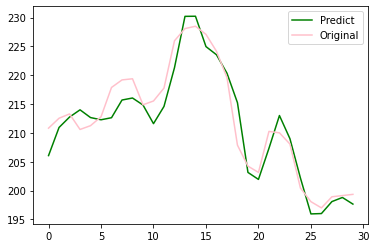

Running time: 19 seconds


In [12]:
#CNN-SED
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


# load the dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_DJH.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)

timestep = 6
dim = 2
#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:2]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)


# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.89)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX)
#print(trainY)
#print(testX)
#print(testY)



#重构数据集
##timestep为时间步长
def create_trainX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_trainY(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i + timestep])
    return np.array(dataY)

def create_testX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[(i):(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------
pres=[]
trainX = create_trainX(trainX, timestep)
trainY = create_trainY(trainY, timestep)
testX = create_testX(testX, timestep) 
testY = testY[timestep:len(testY)]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为4D [samples, subsequences, timesteps, features]
trainX_input4D = np.reshape(trainX, (trainX.shape[0],1,timestep,dim))
testX_input4D = np.reshape(testX, (testX.shape[0],1,timestep,dim))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input4D.shape,testX_input4D.shape)


# create and fit the convlstm network
if __name__ == '__main__':
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=12, kernel_size=3, activation='relu', input_shape=(None,1, testX.shape[1]))))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))

    #model.add(LSTM(4,activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input4D, trainY, epochs=1000)
    


    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input4D)
    testPredict = model.predict(testX_input4D)

    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

#CNN-SED

In [ ]:
#CNN-LSTM-SED
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


# load the dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_DJH.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)

timestep = 6
dim = 2
#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:2]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)


# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.89)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX)
#print(trainY)
#print(testX)
#print(testY)



#重构数据集
##timestep为时间步长
def create_trainX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_trainY(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i + timestep])
    return np.array(dataY)

def create_testX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[(i):(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------
pres=[]
trainX = create_trainX(trainX, timestep)
trainY = create_trainY(trainY, timestep)
testX = create_testX(testX, timestep) 
testY = testY[timestep:len(testY)]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为4D [samples, subsequences, timesteps, features]
trainX_input4D = np.reshape(trainX, (trainX.shape[0],1,timestep,dim))
testX_input4D = np.reshape(testX, (testX.shape[0],1,timestep,dim))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input4D.shape,testX_input4D.shape)


# create and fit the convlstm network
if __name__ == '__main__':
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=36, kernel_size=3, activation='relu', input_shape=(None,1, testX.shape[1]))))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(60,activation='relu',return_sequences=True))
    model.add(LSTM(12,activation='relu',return_sequences=True))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input4D, trainY, epochs=1000)
    


    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input4D)
    testPredict = model.predict(testX_input4D)


    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

#CNN-LSTM-SED

In [ ]:
#GRU_SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_DJH.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 2

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:2]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)

#-------------------------------------------#
#  建立注意力模型
#-------------------------------------------#
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
#    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
#        if print_shape_only:
#            print(layer_activations.shape)
#        else:
#            print(layer_activations)
    return activations

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)#(batch_size, time_steps, input_dim)
    output_attention_mul = Multiply()([inputs, a_probs])#(batch_size, time_steps, input_dim)
    return output_attention_mul


def get_gru_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    gru_units1 = 12
    gru_units2 = 12
    # (batch_size, time_steps, INPUT_DIM) -> (batch_size, input_dim, lstm_units)
    gur_out1 = GRU(gru_units1,return_sequences=True)(inputs)
    gur_out2 = GRU(gru_units2,return_sequences=True)(gur_out1)
    # (batch_size, input_dim, lstm_units) -> (batch_size, input_dim*lstm_units)
    dropout_out = Dropout(0.5)(gur_out2)
    gur_out = Flatten()(dropout_out)
    output = Dense(1, activation='sigmoid')(gur_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.89)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_gru_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    
    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)


    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

#GRU-SED

In [ ]:
#LSTM-SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_DJH.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 2

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:2]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_lstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 12
    lstm_units2 = 36
    lstm_out1 = LSTM(lstm_units1, return_sequences=True)(inputs)
    lstm_out2 = LSTM(lstm_units2, return_sequences=True)(lstm_out1)
    dropout_out = Dropout(0.5)(lstm_out2)
    lstm_out = Flatten()(dropout_out)
    output = Dense(1, activation='relu')(lstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.89)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
        
    model = get_lstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    
    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)


    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

#LSTM-SED

In [ ]:
#Bi-LSTM-SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_DJH.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 2

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:2]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_bilstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 12
    lstm_units2 = 36
    bilstm_out1 = Bidirectional(LSTM(lstm_units1,return_sequences=True),merge_mode='concat')(inputs)
    bilstm_out2 = LSTM(lstm_units2, return_sequences=True)(bilstm_out1)
    dropout_out = Dropout(0.5)(bilstm_out2)
    bilstm_out = Flatten()(dropout_out)
    output = Dense(1, activation='relu')(bilstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.89)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
        
    model = get_bilstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)


    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

#Bi-LSTM-SED